In [21]:
import gym
import numpy as np
import numpy.random as rnd
import os
import mxnet as mx

env = gym.make("MsPacman-v0")

input_height = 88
input_width = 80
input_channels = 1  # we only look at one frame at a time, so ghosts and power pellets really are invisible when they blink
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
#conv_paddings = ["SAME"] * 3
#conv_activation = [tf.nn.relu] * 3
n_hidden_inputs = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512

[2017-09-25 19:49:10,641] Making new env: MsPacman-v0
/home/davis/deeplearningvirtenv/local/lib/python2.7/site-packages/gym/envs/registration.py:17: DeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [22]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0),name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel,
                  stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%i'
                  %(name, suffix))

In [57]:
data = mx.symbol.Variable(name="data")

conv1 = ConvFactory(data=data, num_filter=32, kernel=(8,8), stride=(4,4))
conv2 = ConvFactory(data=conv1, num_filter=64, kernel=(4,4), stride=(2, 2))
conv3 = ConvFactory(data=conv2, num_filter=64, kernel=(4,4), stride=(1,1))



conv1 = mx.sym.Convolution(data=data, num_filter=32, kernel=(8,8),
                  stride=(1,1), pad=(1,1), name='conv1')
bn1 = mx.sym.BatchNorm(data=conv1, name="bn1")
act1 = mx.sym.Activation(data=bn1, act_type='relu',name='act1')

conv2 = mx.sym.Convolution(data=conv1, num_filter=64, kernel=(4,4),
                  stride=(1,1), pad=(1,1), name='conv2')
bn2 = mx.sym.BatchNorm(data=conv2, name="bn2")
act2 = mx.sym.Activation(data=bn2, act_type='relu',name='act2')

conv3 = mx.sym.Convolution(data=conv2, num_filter=64, kernel=(4,4),
                  stride=(1,1), pad=(1,1), name='conv3')
bn3 = mx.sym.BatchNorm(data=conv3, name="bn3")
act3 = mx.sym.Activation(data=bn3, act_type='relu',name='act3')




flat1 = mx.sym.Flatten(data=act3,name="flat1")

fc1 = mx.symbol.FullyConnected(data=flat1, name='fc1', num_hidden=512)
act1 = mx.sym.Activation(data=fc1, name='act1', act_type="relu")
out1 = mx.symbol.FullyConnected(data=act1, name='out1', num_hidden=10)
act2 = mx.symbol.SoftmaxOutput(data=out1,name='softmax')

In [58]:
mnist = mx.test_utils.get_mnist()

[2017-09-25 20:09:30,788] train-labels-idx1-ubyte.gz exists, skipping download
[2017-09-25 20:09:30,791] train-images-idx3-ubyte.gz exists, skipping download
[2017-09-25 20:09:31,151] t10k-labels-idx1-ubyte.gz exists, skipping download
[2017-09-25 20:09:31,153] t10k-images-idx3-ubyte.gz exists, skipping download


In [59]:
batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)


In [62]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on CPU
mlp_model = mx.mod.Module(symbol=act2, context=mx.gpu())
mlp_model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.1},  # use fixed learning rate
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 100), # output progress for each 100 data batches
              num_epoch=10)  # train for at most 10 dataset passes


[2017-09-25 20:10:07,667] Epoch[0] Batch [100]	Speed: 9374.75 samples/sec	accuracy=0.542871
[2017-09-25 20:10:08,854] Epoch[0] Batch [200]	Speed: 8429.10 samples/sec	accuracy=0.925500
[2017-09-25 20:10:09,950] Epoch[0] Batch [300]	Speed: 9129.75 samples/sec	accuracy=0.953900
[2017-09-25 20:10:10,984] Epoch[0] Batch [400]	Speed: 9684.57 samples/sec	accuracy=0.964500
[2017-09-25 20:10:12,016] Epoch[0] Batch [500]	Speed: 9697.22 samples/sec	accuracy=0.970100
[2017-09-25 20:10:13,040] Epoch[0] Train-accuracy=0.971818
[2017-09-25 20:10:13,041] Epoch[0] Time cost=6.616
[2017-09-25 20:10:13,602] Epoch[0] Validation-accuracy=0.977200
[2017-09-25 20:10:14,643] Epoch[1] Batch [100]	Speed: 9665.68 samples/sec	accuracy=0.975050
[2017-09-25 20:10:15,679] Epoch[1] Batch [200]	Speed: 9658.88 samples/sec	accuracy=0.980500
[2017-09-25 20:10:16,716] Epoch[1] Batch [300]	Speed: 9647.59 samples/sec	accuracy=0.978900
[2017-09-25 20:10:17,751] Epoch[1] Batch [400]	Speed: 9671.46 samples/sec	accuracy=0.98320

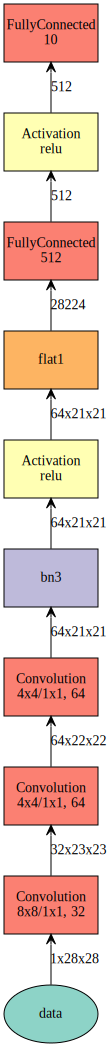

In [50]:
shape = {"data" : (1,1,28, 28)}
mx.viz.plot_network(symbol=out1, shape=shape)